<a href="https://colab.research.google.com/github/ND-CSE-30151/spring-2025/blob/main/15-pda-to-cfg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 15: PDAs to CFGs

In [1]:
#@title Setup
!pip install -qqq tock
from tock import *
!test -x /content/theory || git clone --quiet https://github.com/ND-CSE-30151/spring-2023 /content/theory
%cd -q /content/theory/notes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches, matplotlib.lines as lines

def plot_height(path, subruns=None):
    eps = 0.05 # make top borders of patches not touch
    fig, ax = plt.subplots()
    n = len(path)
    heights = [len(c[2]) for c in path]
    bars = ax.bar(np.arange(n), heights)
    ax.set_xticks(np.arange(n-1)+0.5)
    labels = []
    for i in range(n-1):
        if len(path[i][1]) > len(path[i+1][1]):
            labels.append(path[i][1][0])
        else:
            labels.append("ε")
    ax.set_xticklabels(labels)
    ax.set_xlabel("input string")
    ax.set_yticks(np.arange(max(heights)+1))
    ax.set_ylim(ymax=max(heights)+(n-1)*eps+0.5)
    ax.set_ylabel("stack height")

    for c, b in zip(path, bars):
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2., h-eps, c[0], ha="center", va="top")

    if subruns is None:
        subruns = []
    elif subruns == "all":
        subruns = [(i,j) for i in range(n) for j in range(i+1,n)] # exclude empty

    for (i,j) in subruns:
        if heights[i] != heights[j]:
            continue
        minheight = min(heights[k] for k in range(i,j+1))
        if minheight < heights[i]:
            continue
        maxheight = max(heights[k] for k in range(i,j+1))
        ax.add_patch(patches.Rectangle((i,minheight),
                                       j-i,
                                       maxheight-minheight+(j-i)*eps,
                                       edgecolor='black',
                                       facecolor=('tab:blue', 0.2)))

    plt.show()

## PDAs to CFGs

<div class="alert alert-info"><p><b>Read</b> Section 2.2, Lemma 2.27.</p>
</div>

The conversion from a PDA to a CFG is probably the trickiest to understand of all the constructions we do in this class. Fortunately, though, it's not very difficult to perform.

### Example

Let's start with an example PDA, one that recognizes the language of balanced parentheses but using `a` and `b` for left and right parentheses:

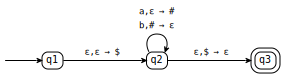

In [2]:
mc = read_csv("pda-parens.csv")
to_graph(mc)

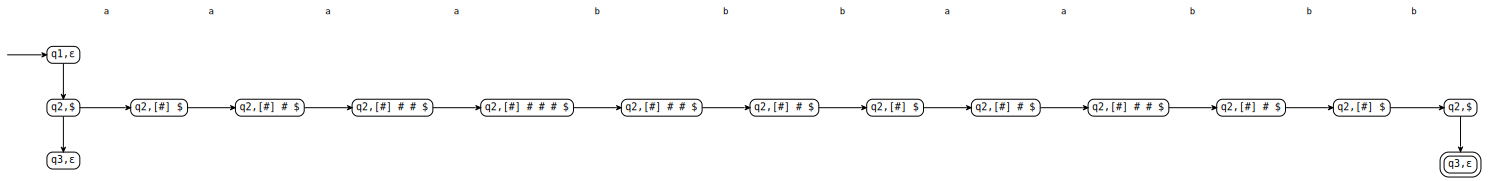

In [3]:
w = list("aaaabbbaabbb")
r = run(mc, w, show_stack=100)
r

The book uses plots of stack height over time (Figure 2.28 and 2.29) to help illustrate the construction.

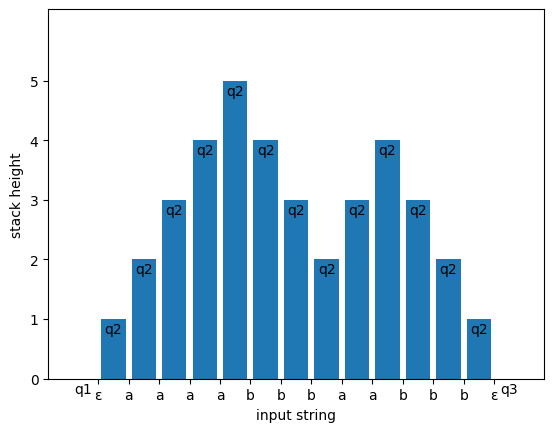

In [4]:
plot_height(r.shortest_path())

Each bar (including bars with zero height) represents a configuration of the machine as it reads the string. The machine's state is written at the top of the bar. The horizontal axis shows the input symbols that are read in (if any) and the vertical axis is the height of the stack. In this case, notice how the stack grows whenever an `a` is read and shrinks whenever a `b` is read.

You can try changing the input string `w` or even the PDA to see how the above graph changes. (However, some figures below will get messed up.)

A sequence of configurations like this is called a _run_. Let's define a _sub-run_ to be a contiguous subsequence of a run that begins and ends with the same stack $t$ and does not pop any symbols in $t$ (not even if it pushes the same symbols back).

For example, the blue rectangle below is a sub-run:

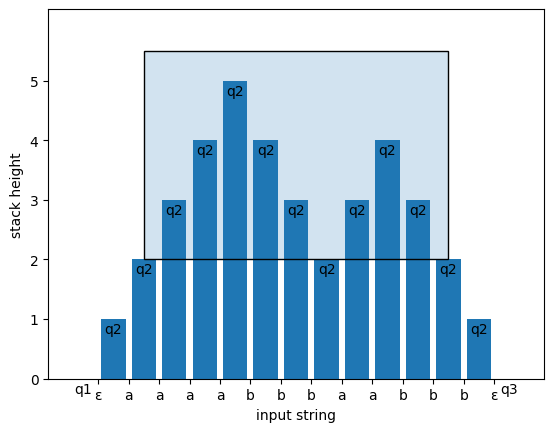

In [5]:
plot_height(r.shortest_path(), subruns=[(2,12)])

Here are all of the sub-runs.

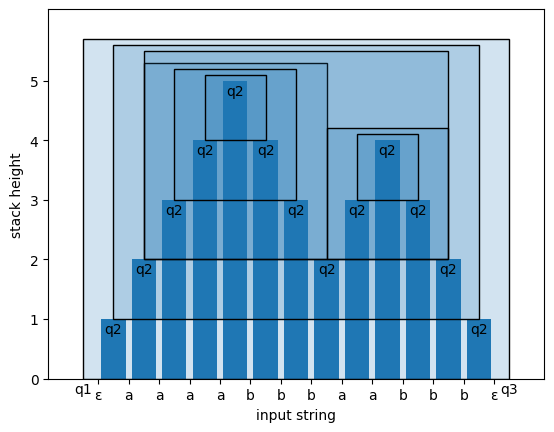

In [6]:
plot_height(r.shortest_path(), subruns="all")

Do you see how the sub-runs are all nested? The idea behind the conversion to CFG is that **sub-runs become sub-trees**. A sub-run that starts in state $q$ and ends in state $r$ is going to become a sub-tree that is rooted in the nonterminal $A_{qr}$.

The whole run is a sub-run. It is generated by the nonterminal symbol $A_{q_1q_3}$, which we make the start symbol. We can picture it as below:

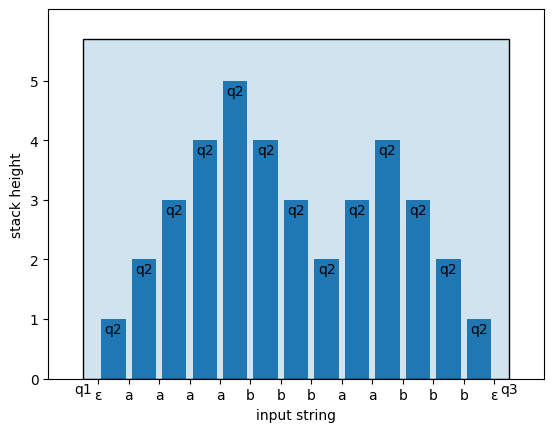

In [7]:
plot_height(r.shortest_path(), subruns=[(0,14)])

Because the run starts and ends with epsilon transitions, there's also a sub-run that covers the whole string but begins in state $q_2$ and ends in state $q_2$:

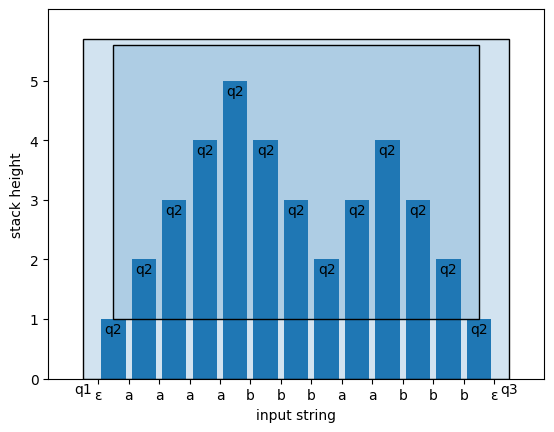

In [8]:
plot_height(r.shortest_path(), subruns=[(0,14),(1,13)])

The sub-run from $q_1$ to $q_3$ is formed out of:
- Reading $\varepsilon$ while going from state $q_1$ to $q_2$,
- A sub-run from $q_2$ to $q_2$,
- Reading $\varepsilon$ while going from state $q_2$ to $q_3$.

So we add a rule $A_{q_1q_3} \rightarrow \varepsilon A_{q_2q_2} \varepsilon$, or simply $A_{q_1q_3} \rightarrow A_{q_2q_2}$.

The next smallest sub-run is the one that covers the whole string except the first and last symbols. It, too, begins in state $q_2$ and ends in state $q_2$:

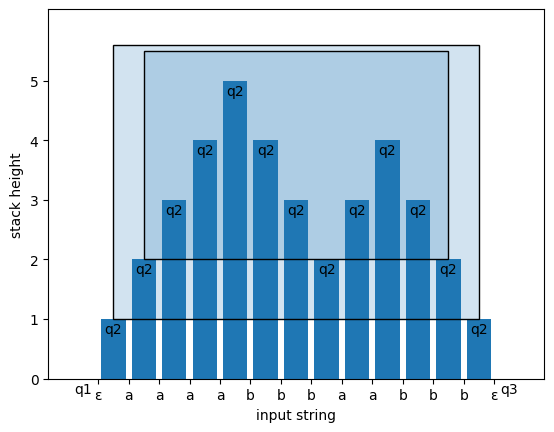

In [9]:
plot_height(r.shortest_path(), subruns=[(1,13),(2,12)])

The larger sub-run from $q_2$ to $q_2$ is formed out of:
- Reading $\texttt{a}$ while going from state $q_2$ to $q_2$,
- A sub-run from $q_2$ to $q_2$,
- Reading $\texttt{b}$ while going from state $q_2$ to $q_2$.

So we add a rule $A_{q_2q_2} \rightarrow \texttt{a} A_{q_2q_2} \texttt{b}$.

Now what is the next smallest sub-run? Notice that if we lop off the first and last symbols again, the result wouldn't be a sub-run. Instead, there are _two_ next-smallest sub-runs:

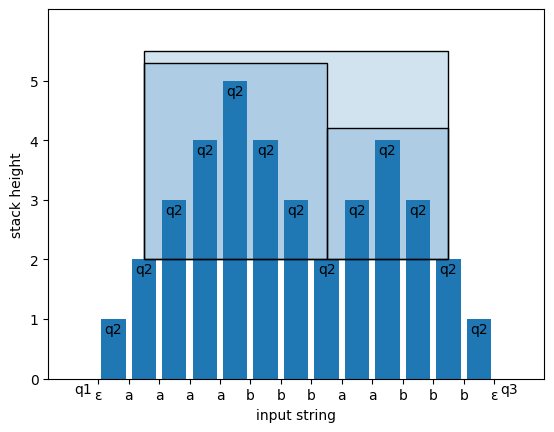

In [10]:
plot_height(r.shortest_path(), subruns=[(2,12),(2,8),(8,12)])

The larger sub-run from $q_2$ to $q_2$ is formed out of:
- A sub-run from $q_2$ to $q_2$,
- Another sub-run from $q_2$ to $q_2$.

So we add a rule $A_{q_2q_2} \rightarrow A_{q_2q_2} A_{q_2q_2}$.

Finally, there are also sub-runs of length 0, so we add a rule $A_{q_2q_2} \rightarrow \varepsilon$. In other words, we can go from $q_2$ to $q_2$ by doing nothing at all.

The conversion from a PDA to a CFG should work for _all_ runs of a PDA, not just one run. Although we've examined only one example run, this example was enough to yield all the CFG rules we need. In summary, the rules are
\begin{align}
A_{q_1q_3} &\rightarrow A_{q_2q_2} \\
A_{q_2q_2} &\rightarrow \texttt{a} A_{q_2q_2} \texttt{b} \\
A_{q_2q_2} &\rightarrow A_{q_2q_2} A_{q_2q_2} \\
A_{q_2q_2} &\rightarrow \varepsilon
\end{align}
with start symbol $A_{q_1q_3}$.

### The general construction

The PDA to CFG construction does this, but not for a particular string; it does this for all possible strings. It starts by putting the PDA into a well-behaved form:

1. If there is more than one accept state, create a new accept state $f'$, make all the old accept states into non-accept states, and add $\varepsilon,\varepsilon\rightarrow\varepsilon$ transitions from every old accept state to $f'$ like this:

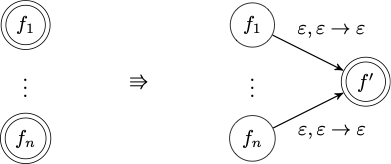

2. If the PDA potentially accepts with a non-empty stack, add states and transitions like this, where state $e$ has many self-loops, one for each stack symbol $x \in \Gamma$:

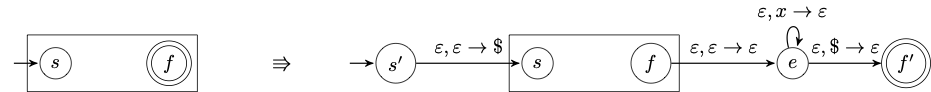

3. If the PDA has any transitions that both push and pop, break them into two transitions like this:


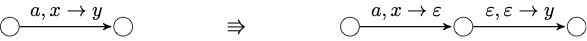

Similarly, if the PDA has any transitions that neither push nor pop, break them into two transitions like this:

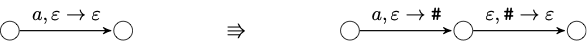

Recall from our examples above that there are three kinds of sub-runs. There is the kind where the stack height doesn't return to the beginning/ending level, and there is the kind that does:

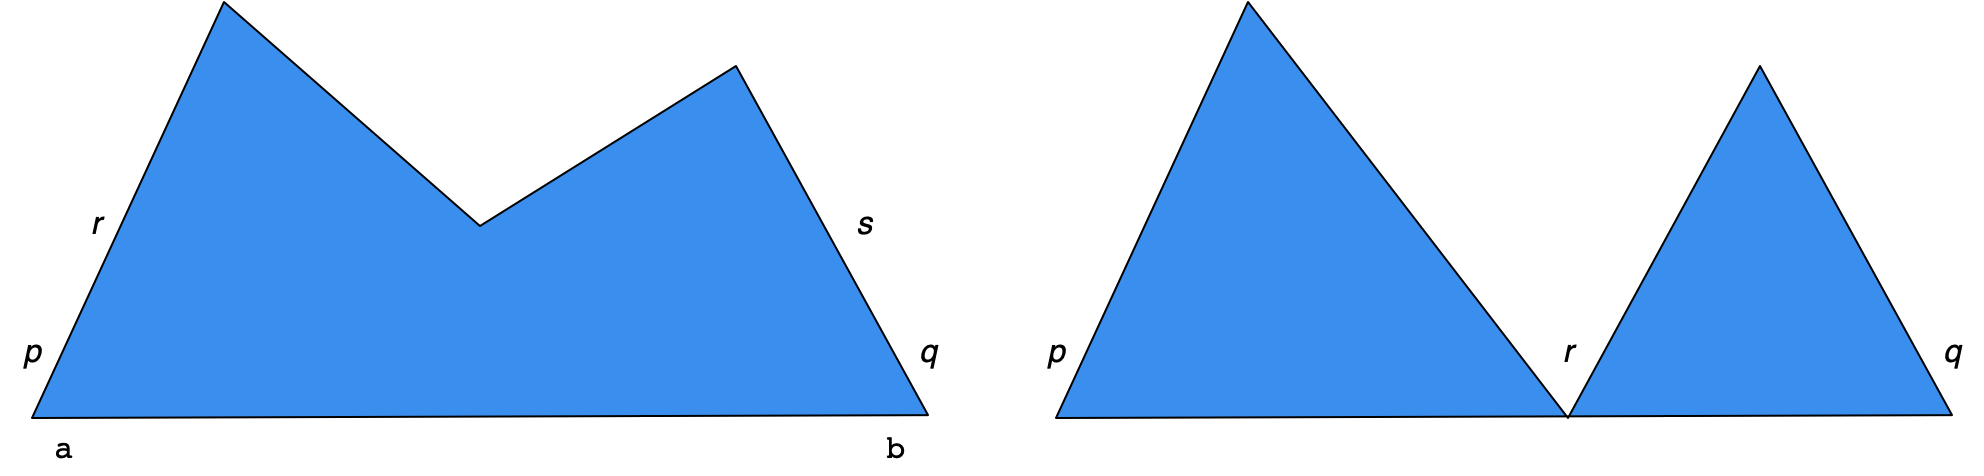

And there is the trivial sub-run, which can't be drawn.

The construction creates CFG rules of three types corresponding to the three kinds of sub-runs.

1. For each pair of transitions of the form

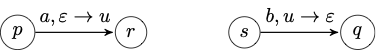

(where $a$ and/or $b$ could be $\varepsilon$), create the rule

$$ A_{pq} \rightarrow a A_{rs} b $$

2. For all states $p, q, r$, create the rule

$$ A_{pq} \rightarrow A_{pr} A_{rq} $$

3. For each state $p$, create the rule

$$ A_{pp} \rightarrow \varepsilon $$

Step 2 creates a *lot* of rules. Typically, most of them are useless. If I ask you to carry out this construction, I don't expect you to write all the rules out. You can intuit which rules are actually useful, or you can just copy the above text for Step 2 verbatim.

Here's what the construction looks like on our example PDA:

In [11]:
to_grammar(mc)

(Tock writes the state $A_{pq}$ as $(p, q)$.)